## SOM-BI_K-means_codebook_ERA5.ipynb

Run K-means clustering on the SOM node groups, using their codebooks instead of their index values

Here only investigte the ERA5 case to ahow that these different node groups and characteristiscs of blockign emerge



In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import csv
import cartopy.crs as ccrs
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.style as style
from scipy import stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D
import random
from itertools import groupby
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import precision_recall_fscore_support
from sklearn.cluster import AgglomerativeClustering
import statsmodels.stats.multitest as multipletests
#import os
#os.environ["PROJ_LIB"] = "C:/Users/carlt/Documents/PhD/Data/"#'C:\\ProgramData\\Anaconda3\\Library\\share\\proj\\'
#from mpl_toolkits.basemap import Basemap as bm
%matplotlib inline

In [71]:
var = "zg"

#define strings for the input GTD and SOM data
if var == "psl":
    var_name_file = "msl"
    SOM_node_list_era5 = "C:/Users/carlt/Documents/PhD/Data/SOM-BI/SOM_node_list_era5_reanal_5x4_EUR_1979-2019_JJA_extd_msl_tot_LTDManom.nc"
    SOM_node_list_cmip = "C:/Users/carlt/Documents/PhD/Data/SOM-BI/SOM_node_list_tot_UKESM1-0-LL_r1i1p1f2_5x4_EUR_1850-2100_JJA_extd_psl_swapERA5.nc"
    GTD_str = "C:/Users/carlt/Documents/PhD/Data/GTD/GTD_1979-2019_JJAextd.nc"
    clus_set_str = "C:/Users/carlt/Documents/PhD/Data/SOM-BI/F1_cv_era5_reanal_5x4_EUR_1979-2019_JJA_extd_msl_tot.nc"
    var_file_str = "C:/Users/carlt/Documents/PhD/Data/reanal/era5/mslp_ERA5_1979-2019_LTDMdaymean_anom_r180x91_EUR_JJAextd.nc"#mslp_ERA5_1979-2019_EUR_JJAextd_LTDMdaymean_anom.nc" 
    codebook_set_str = "C:/Users/carlt/Documents/PhD/Data/SOM-BI/psl_SOM_5x4_ERA5_JJA_1979-2019_codebook.nc"

if var == "zg":
    var_name_file = "z"
    SOM_node_list_era5 = "C:/Users/carlt/Documents/PhD/Data/SOM-BI/SOM_node_list_era5_reanal_5x4_EUR_1979-2019_JJA_extd_zg_tot_LTDManom.nc"
    SOM_node_list_cmip = "C:/Users/carlt/Documents/PhD/Data/SOM-BI/SOM_node_list_tot_UKESM1-0-LL_r1i1p1f2_5x4_EUR_1850-2100_JJA_extd_zg_swapERA5.nc"
    GTD_str = "C:/Users/carlt/Documents/PhD/Data/GTD/GTD_1979-2019_JJAextd.nc"
    clus_set_str = "C:/Users/carlt/Documents/PhD/Data/SOM-BI/F1_cv_era5_reanal_5x4_EUR_1979-2019_JJA_extd_z_tot.nc"
    var_file_str = "C:/Users/carlt/Documents/PhD/Data/reanal/era5/zg/500zg_JJA_1x1_1979-2019_daymean_LTDManom_EurAR5_dtrnd_wrttime.nc" 
    codebook_set_str = "C:/Users/carlt/Documents/PhD/Data/SOM-BI/zg_SOM_5x4_ERA5_JJA_1979-2019_codebook.nc"
    
DG83 = xr.open_dataset("C:/Users/carlt/Documents/PhD/Data/reanal/era5/zg/DG83_clusters_fin_era5_reanal_EUR_JJAextd_1979-2019.nc")['TM90_clusters']>0
DG83_JJA = DG83.sel(time = np.isin(DG83['time.season'], "JJA"))
lats, lons = np.arange(30,78,2), np.arange(-10,42,2)
ec = "k"

persis_thresh = 5
SOM_node_list_era5 = xr.open_dataset(SOM_node_list_era5)['SOM_data']
SOM_node_list_cmip = xr.open_dataset(SOM_node_list_cmip)['SOM_data']

GTD = xr.open_dataset(GTD_str)
GTDsel = GTD.sel(time=~((GTD.time.dt.month == 5) & (GTD.time.dt.day < 28)))
GTD_sel = GTDsel.sel(time=~((GTDsel.time.dt.month == 9) & (GTDsel.time.dt.day > 4)))

ng_set = xr.open_dataset(clus_set_str)['set']

var_file = xr.open_dataset(var_file_str)[var_name_file]
var_file = var_file.sel(time = np.isin(var_file['time.season'], "JJA"))


In [72]:


if "zg" in codebook_set_str:
    vmin, vmax, step = -330, 330, 30
    var = "zg"
    cb_label = "Z$_{500}$ anomaly (m)"
    units = "m"
    upsample_fac = 1
    codebook_div = 1
    vmin_std, vmax_std, step_std = 0, 45*upsample_fac, 5*upsample_fac
elif "psl" in codebook_set_str:
    var = "psl"
    vmin, vmax, step = -22, 22, 2
    cb_label = "MSLP anomaly (hPa)"
    units = "hPa" 
    upsample_fac = 1
    codebook_div = 100
    vmin_std, vmax_std, step_std = 0, 2.00*upsample_fac, 0.25*upsample_fac    
else:
    print("ERROR - var not defined!")

codebook = xr.open_dataset(codebook_set_str)[f'{var}_5x4_codebook']/codebook_div    
    
codebook_flat = codebook.values.reshape(codebook.shape[0]*codebook.shape[1], codebook.shape[2])

In [73]:
n_rows, n_columns = 5, 4
g, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})
g.subplots_adjust(hspace=0.02, wspace=-0.72)

lats, lons = np.arange(30,78,2), np.arange(-10,42,2)
for i in range(n_rows): 
    for j in range(n_columns):
        node=codebook[i][j]
        #print(node)
        node_orig = node.values.reshape(len(lats),len(lons)) 
        ax=axes[i][j]
        
        llons, llats = np.meshgrid(lons, lats)
        
        ax.coastlines(resolution="50m")
        im=ax.contourf(llons, llats, node_orig, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap="seismic", extend='both')
        
        ax.text(0.1,0.9, f'{j+i*4+1}',
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,
               bbox={'facecolor':'white', 'alpha':0.5, 'pad':5, 'linewidth':2, 'edgecolor':'k'},
            fontsize=10)        
        
width, height = 0.4,0.05
cbaxes = g.add_axes([0.31,0.03, width, height])        
cb = g.colorbar(im, cax=cbaxes, orientation="horizontal")

cb.set_label(cb_label)
#g.savefig(f"C:/Users/carlt/Documents/PhD/Plots/SOM_BI_comp/NGs/SOM_ERA5_zg_5x4.png", bbox_inches="tight", dpi = 300)  

C:\Users\carlt\.conda\envs\odin\lib\site-packages\cartopy\mpl\geoaxes.py:1391: UserWarning: The following kwargs were not used by contour: 'latlon'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


From the 624 elements in the codebook, can plot each of them and can plot the average codebook for each node group

In [74]:
def clus_to_str(clus):
    """
    Convert array of node numbers to a string
    """
    clus_str = str(clus.values)
    clus_str_corr = (clus_str.replace(".", "").replace("[", "").replace("]", "").replace(" ", "_").replace("__", "_"))
    if clus_str_corr[0] == "_":
        clus_str_corr = clus_str_corr[1:]
    return clus_str_corr

In [75]:

def codebook_comb_arr_calc(ng_set, codebook_flat):
    """
    Calculate the combined codebook vectors for each group of nodes in the total node group set
    
    codebook_flat - the flattened codebook vectors (shape: node num x lat/lon coords)
    """
    codebook_comb_arr = []
    for ng in ng_set:
        codebook_comb = np.zeros((624))
        node_idx_arr=[int(i)-1 for i in clus_to_str(ng).split("_")] #nodes assocaited with each cluster
        #calculate the mean codebook vector across all of the SOm nodes in each codebook
        for node_idx in node_idx_arr:
            codebook_comb += codebook_flat[node_idx]
        codebook_comb = codebook_comb / len(node_idx_arr)
        codebook_comb_da = xr.DataArray(codebook_comb, name = "codebook_comb")
        codebook_comb_da = codebook_comb_da.rename({"dim_0": "lat_lon_flat"})
        codebook_comb_da['cluster'] = ng.values
        codebook_comb_da['lat_lon_flat'] = np.arange(codebook_comb.shape[0])
        codebook_comb_arr.append(codebook_comb_da)    
    return xr.concat(codebook_comb_arr, dim= "clusters")




In [76]:
codebook_comb_arr=codebook_comb_arr_calc(ng_set, codebook_flat)



First plot every codebook and the combined node groups

C:\Users\carlt\.conda\envs\odin\lib\site-packages\cartopy\mpl\geoaxes.py:1391: UserWarning: The following kwargs were not used by contour: 'latlon'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


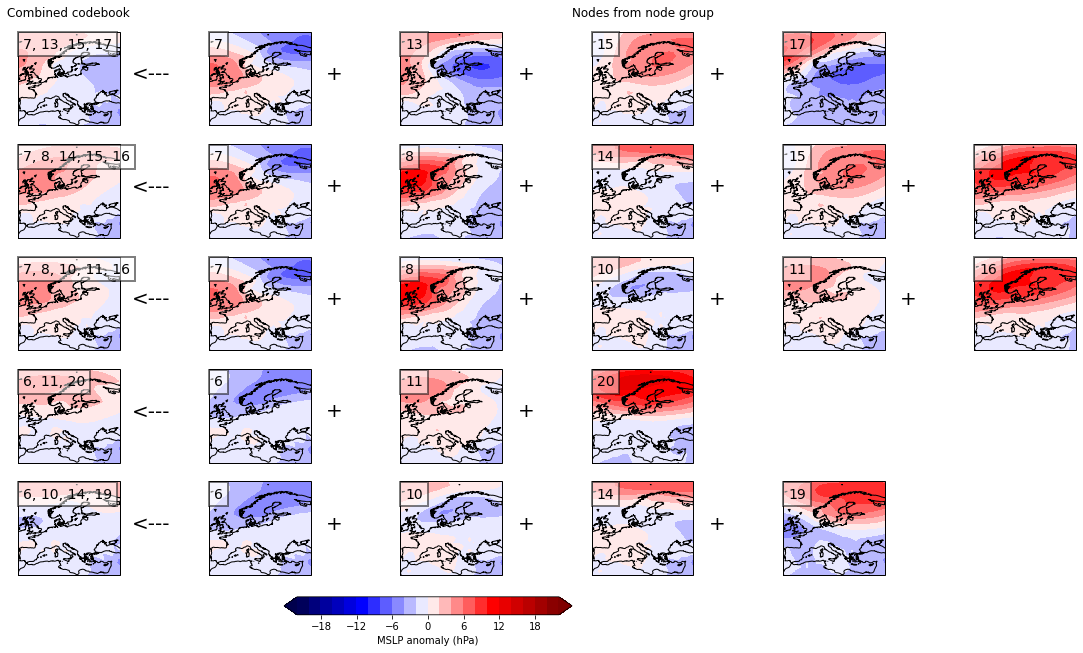

In [8]:

num_rows = 5
num_columns = 6#len(node_idx_arr)+1

#var_file[clus_era5==1].mean(axis=0).plot()
#(var_file[clus_era5==1]>100).mean(axis=0).plot()
g.subplots_adjust(hspace = 0.1, wspace = -0.5)

for idx in [7]:#range(32):
        #idx
    g, axes = plt.subplots(nrows = num_rows, ncols = num_columns, figsize = (20,10), subplot_kw = {'projection': ccrs.PlateCarree()})    
    axes[0,0].set_title("Combined codebook", pad = 15)        
    axes[0,3].set_title(f"Nodes from node group", pad = 15)  

    for j, codebook_comb in enumerate(codebook_comb_arr[idx*num_rows:(idx+1)*num_rows]):
        ng=codebook_comb['cluster']
        node_idx_arr=[int(i)-1 for i in clus_to_str(ng).split("_")]

        for i, ax in enumerate(axes[j]):

            if i == 0:
                codebook_plot = codebook_comb.values.reshape(len(lats),len(lons))
                node_orig = codebook_comb.values.reshape(len(lats),len(lons))
                caption = clus_to_str(ng).replace("_", ", ")
                #add arrow to plot
                #ax.arrow(x=100, y=50, dx=10, dy=50, width=15, facecolor='red') 
                ax.text(1.12,0.65, "<---",
                        horizontalalignment='left',
                        verticalalignment='top',
                        transform=ax.transAxes,
                        fontsize=20) 

            elif i < len(node_idx_arr)+1:
                codebook_plot = codebook_flat[node_idx_arr[i-1]].reshape(len(lats),len(lons))
                caption = node_idx_arr[i-1]+1
                if i < len(node_idx_arr):
                    ax.text(1.15,0.65, "+",
                            horizontalalignment='left',
                            verticalalignment='top',
                            transform=ax.transAxes,
                            fontsize=20) 
            if i < len(node_idx_arr)+1:
                ax.coastlines(resolution = "50m")
                ax.contourf(llons, llats, codebook_plot, np.arange(vmin, vmax+step, step), \
                        latlon=True, cmap="seismic", extend='both')
                ax.text(0.05,0.94, caption,
                        horizontalalignment='left',
                        verticalalignment='top',
                        transform=ax.transAxes,
                           bbox={'facecolor':'white', 'alpha':0.5, 'pad':5, 'linewidth':2, 'edgecolor':ec},
                        fontsize=14) 

            else:
                g.delaxes(ax) #delete the axes that don'e need to be plotted


    width, height = 0.2,0.025
    cbaxes = g.add_axes([0.33,0.07, width, height])        
    cb = g.colorbar(im, cax=cbaxes, orientation="horizontal")

    cb.set_label(cb_label)

    g.savefig(f"C:/Users/carlt/Documents/PhD/Plots/SOM_BI_comp/NGs/{var}_20nodes_NG_comb_{idx*num_rows}-{(idx+1)*num_rows}.png", bbox_inches="tight", dpi = 300)  
    g.savefig(f"C:/Users/carlt/Documents/PhD/Plots/SOM_BI_comp/NGs/{var}_20nodes_NG_comb_{idx*num_rows}-{(idx+1)*num_rows}.pdf", bbox_inches="tight", dpi = 300) 
    #plt.close();

In [77]:


def upsample_ng_set(ng_set):
    """
    Upsample the node group set such that each cluster contains 60 elements.
    This enables a direct comparison of clustering of the nodes to take place.
    Assumes that the five day persistence criterea is being used and no more than 5 nodes are part of each node group
    """
    upsample_fac = 1 #upsampling factor to account for the random shuffling of the elements
    ng_set_upsampled = []
    for ng in ng_set:
        ng_arr = np.array([int(i) for i in list(filter(None, str(ng.values).replace("[", "").replace("]", "").replace(" ", "").split(".")))])
        if len(ng_arr) == 1:
            arr=np.ones((60*upsample_fac))*ng_arr[0]
        if len(ng_arr) == 2:
            arr=np.concatenate([np.ones((30*upsample_fac))*ng_arr[0], np.ones((30*upsample_fac))*ng_arr[1]])
        if len(ng_arr) == 3:
            arr=np.concatenate([np.ones((20*upsample_fac))*ng_arr[0], np.ones((20*upsample_fac))*ng_arr[1], np.ones((20*upsample_fac))*ng_arr[2]])
        if len(ng_arr) == 4:
            arr=np.concatenate([np.ones((15*upsample_fac))*ng_arr[0], np.ones((15*upsample_fac))*ng_arr[1], np.ones((15*upsample_fac))*ng_arr[2], np.ones((15*upsample_fac))*ng_arr[3]])
        if len(ng_arr) == 5:
            arr=np.concatenate([np.ones((12*upsample_fac))*ng_arr[0], np.ones((12*upsample_fac))*ng_arr[1], np.ones((12*upsample_fac))*ng_arr[2], np.ones((12*upsample_fac))*ng_arr[3], np.ones((12*upsample_fac))*ng_arr[4]]) 
        np.random.shuffle(arr) # note that there is a sensitivity to the shuffling of the node elements
        ng_set_upsampled.append((arr))
    return np.array(ng_set_upsampled)
    
    
ng_set_upsampled = upsample_ng_set(ng_set)    

In [78]:
def codebook_all_agree(codebook_comb_clus):
    """
    find where all signs agree/disagree in the combined codebook
    """
    codebook_comb_clus_allneg=codebook_comb_clus.where(codebook_comb_clus<0).sum(axis=0, skipna=False)<0
    codebook_comb_clus_allpos=codebook_comb_clus.where(codebook_comb_clus>0).sum(axis=0, skipna=False)>0
    codebook_comb_clus_allagree=((((codebook_comb_clus_allpos.values+1-1)+(codebook_comb_clus_allneg.values+1-1))>0)+1-1).reshape(len(lats),len(lons))
    return codebook_comb_clus_allagree


def codebook_prop_agree(codebook_comb_clus, prop = 0.95):
    """
    find the grid cells where a specified proportion of the codebooks agree/disagree in the combined codebook
    """
    #calculate the proportion of codebooks which do not agree
    codebook_comb_clus_propneg = ((((codebook_comb_clus.where(codebook_comb_clus<0)<0)+1-1).sum(axis=0)/codebook_comb_clus.shape[0])>prop)
    codebook_comb_clus_proppos = ((((codebook_comb_clus.where(codebook_comb_clus>0)>0)+1-1).sum(axis=0)/codebook_comb_clus.shape[0])>prop)
    codebook_comb_clus_propagree=((((codebook_comb_clus_proppos.values+1-1)+(codebook_comb_clus_propneg.values+1-1))>0)+1-1).reshape(len(lats),len(lons))
    return codebook_comb_clus_propagree



In [79]:
codebook_flat_da_rn = xr.DataArray(codebook_flat, name="codebook_flat")
codebook_flat_da = codebook_flat_da_rn.rename({"dim_0": "nodes", "dim_1": "lat_lon_flat"})
codebook_flat_da['nodes'] = np.arange(20)
codebook_flat_da['lat_lon_flat'] = np.arange(624)


In [80]:

def codebook_upsampled_vals(codebook_flat_da, ng_set_upsampled, labels, clus, lat_len, lon_len):
    """
    Returns the mean, std and places where all values agree
    for each node group set with the accompanying labels
    Takes a minute or so to run
    """
    codebook_upsampled_arr = []
    for node in ng_set_upsampled[labels==clus].flatten()[:]-1:
        codebook_upsampled_arr.append(codebook_flat_da[int(node),:])
    codebook_upsampled_arr_concat = xr.concat(codebook_upsampled_arr, dim = "nodes")    
    print(codebook_upsampled_arr_concat.shape)
    codebook_upsampled_std = codebook_upsampled_arr_concat.std(axis=0).values.reshape(lat_len, lon_len)
    codebook_upsampled_mean = codebook_upsampled_arr_concat.mean(axis=0).values.reshape(lat_len, lon_len)
    codebook_upsampled_allagree = codebook_all_agree(codebooks_upsampled_arr_concat)
    codebook_upsampled_propagree = codebook_prop_agree(codebooks_upsampled_arr_concat)
    
    return codebook_upsampled_mean, codebook_upsampled_std, codebook_upsampled_allagree, codebook_upsampled_propagree




In [15]:

fig = plt.figure()
#create elbow and silhouette plots to identify the optimatl number of clusters
estimators = []
avg_distance = []
sse, db, slc = {}, {}, {}
K_clusters = [3]#range(7,8,1)
for clus in K_clusters:
    estimators.append( (f'K means for {clus} clusters', KMeans(n_clusters=clus, init='k-means++', n_init=30, max_iter=300, tol=1e-4).fit(codebook_comb_arr)))

    
for i, (name, est) in enumerate(estimators[:]):
    K_clus = K_clusters[i]
    #K_means = est.fit(codebook_comb_arr)
    clusters = est.labels_
    sse[K_clus] = est.inertia_
    db[K_clus] = davies_bouldin_score(codebook_comb_arr, clusters)
    #print(davies_bouldin_score(codebook_comb_arr.values, K_means))





<Figure size 432x288 with 0 Axes>

In [81]:
def return_periods_da(da, year_avg, year_shift, scale_zero_rt=1.25):
    """
    Function to calculate reutrn periods from a series of results
    year_avg - the number of years included within each return time calculation
    year_shift - the number of years to shift the moving window calculation by
    da - DataArray showing the occurrence of the identified events with daily timestamps
    Return time T: A return period, also known as a recurrence interval or repeat interval, is an average time or an estimated average time between events
    T = (n + 1)/m
    n - number of years on record
    m - number of recorded occurrences of the event being considered
    NB Assumes that the probability of more than one occurrence per year is zero. May need to check this assumption with the minimum length of five days for a block
    scale_zero_rt - if return time calculation would yield infinity, scale the value to be larger than the sampling period by this factor
    """
    JJA_days = 92
    styr, endyr = int(da['time.year'].min()), int(da['time.year'].max())
    num_yrs = len(np.unique(da['time.year']))
    T_arr, occ_arr, persis_arr, max_dur_arr, event_no_arr, mid_yr_arr = [], [], [], [], [], []
    #calculate moving averges for the specific time windows
    for i in range(int(num_yrs/year_shift)):
        if (styr + i*year_shift) + year_avg < endyr + 2:
            da_sel = da.sel(time = np.isin(da['time.year'], np.arange(styr + i*year_shift, (styr + i*year_shift) + year_avg)))
            occ, tot_sum = float(da_sel.mean()), int(da_sel.sum())
            styr_samp = int(da_sel['time.year'].min())
            num_yrs_samp = len(np.unique(da_sel['time.year']))
            mid_yr_samp = styr_samp+num_yrs_samp/2
            #calculation of time metrics (persistence, max duration and event number) on a yearly basis
            da_yrs=list(da_sel.groupby("time.year"))
            streaks = [[sum(1 for i in g) for k, g in groupby(da[1].values) if k == 1] for da in da_yrs]
            streak_count = [[(k, sum(1 for i in g)) for k,g in groupby(sorted(x)) ] for x in streaks]
            persis_yr = [sum([x[0]*x[1] for x in year])/sum([x[1] for x in year]) if sum([x[1] for x in year]) != 0 else 0 for year in streak_count ]
            max_dur_yr = [year[-1][0] if year != [] else 0 for year in streak_count]
            event_no_yr = [consecutive_one_len(da[1].values) for da in da_yrs]             
            #calculate time metrics for annual basis
            persis = np.mean(persis_yr)
            max_dur = max(max_dur_yr)
            event_no = sum(event_no_yr)
            
            if tot_sum > 0:
                T = (num_yrs_samp + 1)/tot_sum
            else:
                T = year_avg*scale_zero_rt
            occ_arr.append(occ*JJA_days)
            persis_arr.append(persis)
            max_dur_arr.append(max_dur)
            event_no_arr.append(event_no/year_avg)
            T_arr.append(T)
            mid_yr_arr.append(mid_yr_samp)
    return T_arr, occ_arr, persis_arr, max_dur_arr, event_no_arr, mid_yr_arr

def len_iter(items):
    return sum(1 for _ in items)  

def consecutive_one_len(data):
    return len(list(len_iter(run) for val, run in groupby(data) if val))
    

In [82]:
from itertools import groupby
from operator import itemgetter

def get_longest_consecutive_numbers(numbers):
    idx = max(
        (
            list(map(itemgetter(0), g)) 
            for i, g in groupby(enumerate(np.diff(numbers)==1), itemgetter(1)) 
            if i
        ), 
        key=len
    )
    return (idx[0], idx[-1]+1)


In [16]:

clus_cmip_ng, clus_era5_comp= np.zeros((22590)), np.zeros((3772))

#identify where there are events which are only associated with individual node groups
for ng in ng_set[:]:
    ng_str = clus_to_str(ng)
    clus_era5_tot = xr.open_dataset(f"C:/Users/carlt/Documents/PhD/Data/SOM-BI/Clusters/era5_reanal_1979-2019_SOM-BI_5x4_{var}_{ng_str}.nc")[ng_str]
    clus_era5 = clus_era5_tot.sel(time=np.isin(clus_era5_tot['time.season'], "JJA"))
    #era5_da = xr.DataArray((clus_era5_ng>0)+1-1, name=f"era5_BI_clus{clus}")
    #era5_da = era5_da.rename({"dim_0": "time"})
    #era5_da['time'] = clus_era5['time']
    clus_era5_comp += clus_era5.values
    
era5_da_comp = xr.DataArray(clus_era5_comp, name="era5_BI_comp")
era5_da_comp = era5_da_comp.rename({"dim_0": "time"})             
era5_da_comp['time'] = clus_era5['time']            
blocked_one_ng = era5_da_comp['time'][np.where(era5_da_comp.values == 1)] 

In [83]:
GTD_JJA=GTD.sel(time=np.isin(GTD['time.season'], "JJA"))

In [41]:
len(blocked_one_ng)/GTD_JJA.sum()

#44% of the blocked days in the GTD are associated with only one node group, and that includes several periods in the GTD
#42% for psl


<xarray.DataArray 'blocking' ()>
array(0.42527822)

In [84]:
def lag1corr(X): 
    """Compute the lag-1 autocorrelation coefficient for time series X"""
    n = len(X)
    meanx = np.mean(X)
    num = 0
    den = 0
    for i in range(n-1):
        num += (X[i+1] - meanx) * (X[i] - meanx)
    for i in range(n): 
        den += (X[i] - meanx)**2
    r = num/den # lag-1 correlation coefficient
    return r

def ESS(X): 
    """X is a time series
    Output is the equivalent sample size as suggested by Zwiers and von Storch
    """
    n = len(X)
    ## compute the sample lag-1 correlation coefficient
    r = lag1corr(X)
    n_e = n*(1-r)/(1+r)
    # n_e = n*(1-abs(r))/(1+abs(r))  # use the absolute calue of lag-1 correlation coefficient
    # estimated equivalent sample size
    if n_e <= 2: 
        eess = 2
    elif 2<n_e<=n: 
        eess = n_e
    else: 
        eess = n
    return eess

def RSS(y, yhat): 
    """y are the true values of response variable
    yhat are the predicted values of response variable
    The output is the residual sum of squares"""
    N = len(y)
    rss = 0
    for i in range(N): 
        rss += (y[i]-yhat[i])**2
    return rss

def lmtrendtest(x, y): 
    """ x is the time, y is the observation
    Output: test statistic, p-value using standard Normal, p-value using student t 
    for the slop of linear least squares regression"""
    # fit a linear regression
    m, c, r, p, err = scipy.stats.linregress(x,y) # slope, intercept, correlation, pvalue, std error
    # make a design matrix
    N = len(y)
    x0 = np.ones(N)
    X = np.column_stack((x0,x)) # design matrix with two columns, intercept & time
    # calculate the test statistic
    a = np.linalg.inv(np.matmul(X.transpose(),X))[1,1]
    ess = ESS(y) # equivalent sample size
    yhat = [c+i*m for i in x]
    rss = RSS(y, yhat) # residual sum of squares
    t = m / (np.sqrt(a*rss/(ess-2)))
    # p-value using standard normal (two tail test)
    p_value_normal = scipy.stats.norm.sf(abs(t))*2
    # p-value using student t (two tail)
    p_value_student = stats.t.sf(np.abs(t), ess-2)*2
    # lag1 autocorrelation coefficient
    rho = lag1corr(y)
    if np.isnan(p_value_student):
        p_value_student = 1
    return p_value_normal#p_value_student #rho, p, 

def Bonferroni_kFWER(pvals, k = 2):
    """
    Apply the Bonferroni correction to the pvalues
    From Horton et al. (2015):
    "One option for the value of k is to use the expected number of
    hypotheses that will be rejected at a given significance level. 
    For instance, in our study, out of 112 total ‘local’ hypotheses,
    5 or 6 hypotheses will be significant at the 5% significance 
    level by chance (112 3 0.05 5 5.6). In this case, one can evaluate
    the probability that 7 or more hypotheses are falsely rejected,
    since on average about 6 could be rejected as significant by chance.
    Using this logic, for 9 nodes, 8 tests and alpha = 0.05 use k = 5 (1+9*8*0.05 rounded up)
    """
    pvals_corr = [len(pvals)*p/k if len(pvals)*p/k < 1 else 1 for p in pvals]
    return np.array(pvals_corr)


In [86]:
#run K means clustering on the combination of codebook elements
#cluster the 157 node groups together across 624 elements
estimators = []
K_clusters = [4]#[14]#range(8,14,2)
for clus in K_clusters:
    estimators.append( (f'K means for {clus} clusters', KMeans(n_clusters=clus)))
    
name, est = estimators[0]    
est.fit(codebook_comb_arr)
labels_rnd = est.labels_


In [72]:
da_clus_ng_arr = [xr.open_dataset(f"C:/Users/carlt/Documents/PhD/Data/SOM-BI/NG_clus_4_class_era5_zg_lab{i}_{lab}.nc") for i, lab in enumerate(["N", "NW", "NE", "E"])]

In [17]:
labels = labels_rnd.copy()#["N", "NW", "NE", "E"]

In [92]:

#correct ordering of the labels for each node group for both psl and zg with a cluster of 4 different events. They have been labelled as N Eur, NW Eur, NE Eur and E Eur blocking events.
labels_corr_psl = np.array([1, 3, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 1, 2,
       1, 2, 1, 0, 2, 0, 1, 1, 1, 1, 1, 2, 3, 3, 1, 1, 2, 3, 3, 3, 3, 3,
       1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 2, 2, 2, 3, 3, 3, 2, 0, 0, 2, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 0, 0, 1, 1, 0, 1, 2, 1, 2, 0,
       2, 2, 2, 2, 2, 0, 3, 3, 3, 3, 1, 3, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1,
       0, 1, 2, 0, 1, 2, 0, 1, 1, 2, 0, 1, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2,
       3, 2, 1])


labels_corr_zg = np.array([0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 1, 0, 1, 3, 3, 2, 2, 2, 1,
       3, 1, 0, 1, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 2, 1, 1, 0, 2, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 1, 1, 3, 2, 2, 2, 1, 0, 1, 3, 2, 0, 2, 2, 3, 1, 3, 2, 2, 1, 0,
       3, 0, 2, 0, 0, 2, 0, 2, 0, 0, 3, 0, 0, 2, 1, 1, 1, 3, 2, 1, 0, 0,
       3, 3, 1, 1])

In [93]:
labels=labels_corr_zg

K_clus = 4
clus = 0


C:\Users\carlt\.conda\envs\odin\lib\site-packages\cartopy\mpl\geoaxes.py:1391: UserWarning: The following kwargs were not used by contour: 'latlon'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


clus = 1


C:\Users\carlt\.conda\envs\odin\lib\site-packages\cartopy\mpl\geoaxes.py:1391: UserWarning: The following kwargs were not used by contour: 'latlon'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


clus = 2


C:\Users\carlt\.conda\envs\odin\lib\site-packages\cartopy\mpl\geoaxes.py:1391: UserWarning: The following kwargs were not used by contour: 'latlon'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


clus = 3


C:\Users\carlt\.conda\envs\odin\lib\site-packages\cartopy\mpl\geoaxes.py:1391: UserWarning: The following kwargs were not used by contour: 'latlon'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Plotting total set


NameError: name 'era5_da_comp' is not defined

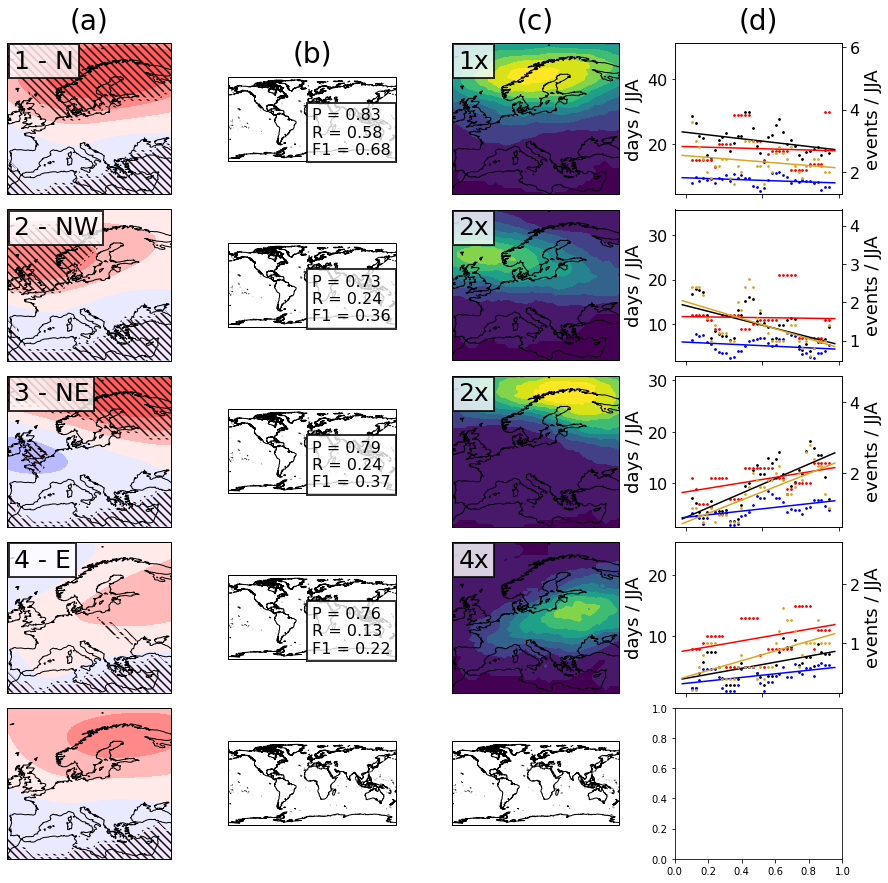

In [94]:

year_avg, year_shift = 5, 1
clus_cmip_comp, clus_era5_comp = np.zeros((22590)), np.zeros((3772))
bins = np.arange(0.5,21.5,1)
era5_da_arr, cmip_da_arr = [], []
avg_title_cb = "(a)"#"Map of combined codebooks"#"Averaged map of the \n combined codebooks for each cluster \n hatching where all combined codebooks \n agree on the sign of the grid cell"
std_title_cb = "(c)"#"Blocking climatology"#"Standard devation of the \n combined codebooks for each cluster"
avg_title_upsamp = "Averaged map of the \n combined upsampled SOM nodes for each cluster \n hatching where all combined codebooks \n agree on the sign of the grid cell"
std_title_upsamp = "Standard devation of the \n combined upsampled SOM nodes for each cluster"
hst_title = "(b)"#"Averaged Z$_{500}$ maps"
trnds_title = "(d)"#"Trends"
trnd_titles = ["Return times ( JJA )", "Occurrence of event (%)", "Persistence of event (days)", "Max duration of event (days)", f"Number of events (per {year_avg} yrs)"]

fs_title = 28
fs_text = 22
fs_cb = 15
fs_leg = 15
fs_scores = 16
fs_lab = fs_scores
fs_xylabs = 18
alpha_textbox = 0.8
lat_len, lon_len = len(lats), len(lons)

if "longitude" in str(var_file.coords):
    lat_str, lon_str = "latitude", "longitude"
else:
    lat_str, lon_str = "lat", "lon"

llons_var, llats_var = np.meshgrid(var_file[lon_str], np.arange(30,76))
llons_var, llats_var_rev = np.meshgrid(var_file[lon_str], var_file[lat_str])

llons, llats = np.meshgrid(np.arange(-10,42,2), np.arange(30,78,2))

prop = 0.8 # proportion to plot on hatching where the majority agree
pad_title = 15
GTD_JJA = GTD.sel(time = np.isin(GTD['time.season'], "JJA"))['blocking']
fac_arr = [1,2,2,4,1]
vmin_blo, vmax_blo, step_blo = 0, 8, 1

top_left_xy = (0.04, 0.96)
bot_right_xy = (0.5, 0.04)

codebook_comb_clus_avg_arr, codebook_comb_clus_allagree_arr, blo_clim_arr, blocked_days_arr_mean_arr, occ_arr_era5_arr, persis_arr_era5_arr, max_dur_arr_era5_arr, event_no_arr_era5_arr, blocked_days_arr_tot, DG83_tot = [], [], [], [], [], [], [], [], [], []

clus_era5_ng_arr = []

codebook_comb_clus_avg_tot, codebook_comb_clus_allagree_tot, codebook_comb_clus_std_tot = np.zeros((lat_len, lon_len)), np.zeros((lat_len, lon_len)), np.zeros((lat_len, lon_len))
K_clus = 4
hst_max = int(1000/(K_clus*0.5))    
num_columns, num_rows = 4, K_clus+1
g = plt.figure(figsize = (15,15))  
g.subplots_adjust(hspace = 0.1, wspace = 0.33)    
print(f"K_clus = {K_clus}")
suptitle = f"SOM-BI classification for {K_clus} node group (NG) clusters \n scatter plot metrics calculated over {year_avg} year slices with a {year_shift} year shift"
ylabel="Node frequency \n (x 60)"
xlabel="Node number"     
col_evno = tuple(np.array([218,165,32])/255) # gold
#(1,0,1) magenta
pval_corr_arr, m_arr, ax4_arr = [], [], []
max_xlim_fac = 1.7 # factor to extend the maximum value of the trend to make space for the labelsof gradients and p values
min_xlim_fac = 0.8
evno_ylab = "events / JJA"
yr_lab, days_lab = "years", "days / JJA"
clus_era5_ng_arr = []
clus_lab = ["1 - N", "2 - NW", "3 - NE", "4 - E", "tot"]

for clus in range(K_clus):
    blocked_days_arr, DG83_arr = [], []
    print(f"clus = {clus}")
    codebook_comb_clus = codebook_comb_arr[labels==clus]
    codebook_comb_clus_avg = np.array(codebook_comb_clus).mean(axis=0).reshape(lat_len, lon_len)
    codebook_comb_clus_std = np.array(codebook_comb_clus).std(axis=0).reshape(lat_len, lon_len)
    #find where all signs agree/disagree in the combined codebook
    codebook_comb_clus_allagree = codebook_all_agree(codebook_comb_clus)
    clus_cmip_ng, clus_era5_ng = np.zeros((22590)), np.zeros((3772))
    for ng in ng_set[labels==clus]:
        ng_str = clus_to_str(ng)
        clus_era5_tot = xr.open_dataset(f"C:/Users/carlt/Documents/PhD/Data/SOM-BI/Clusters/era5_reanal_1979-2019_SOM-BI_5x4_{var}_{ng_str}.nc")[ng_str]
        clus_era5 = clus_era5_tot.sel(time = np.isin(clus_era5_tot['time.season'], "JJA"))
        clus_era5_ng += clus_era5.values
        clus_era5['time']=DG83_JJA['time']
        var_file['time']=DG83_JJA['time']
        #print(var_file[clus_era5==1])
        blocked_days_arr.append(var_file[clus_era5==1])
        #print(blocked_days_arr)
        blocked_days_arr_tot.append(var_file[clus_era5==1])
        clus_era5_comp += clus_era5.values
        DG83_arr.append(DG83_JJA[clus_era5==1])
        DG83_tot.append(DG83_JJA[clus_era5==1])   
    clus_era5_ng_arr.append(clus_era5_ng)
    #blocked_days_arr_mean = xr.concat(blocked_days_arr, dim = "time").mean(axis=0)
    blo_clim = DG83_JJA[np.where(clus_era5_ng>0)].sum(axis=0)*100/3772#(xr.concat(DG83_arr, dim = "time")).sum(axis=0)/3772
    #blocked_days_arr_thresh.mean(axis=0).plot()
    ax1 = plt.subplot2grid((num_rows, num_columns), (clus, 0), projection=ccrs.PlateCarree())
    ax2 = plt.subplot2grid((num_rows, num_columns), (clus, 1), projection=ccrs.PlateCarree())   
    ax3 = plt.subplot2grid((num_rows, num_columns), (clus, 2), projection=ccrs.PlateCarree())  
    ax4 = plt.subplot2grid((num_rows, num_columns), (clus, 3))

    if clus == 0:
        ax1.set_title(avg_title_cb, fontsize=fs_title, pad=pad_title)
        ax3.set_title(std_title_cb, fontsize=fs_title, pad=pad_title)  
        ax2.set_title(hst_title, fontsize=fs_title, pad=pad_title)
        ax4.set_title(trnds_title, fontsize=fs_title, pad=pad_title)
    #for ax, title in zip(trnd_axs, trnd_titles):                  
    #    ax.set_title(title, fontsize=fs_title, pad=pad_title)
    #plot the average and standard deviation for the cluster averages of the combined codebooks
    for ax in [ax1, ax3, ax2]:
        ax.coastlines(resolution = "50m")
    #llons_var, llats_var = 
    im_avg = ax1.contourf(llons, llats, codebook_comb_clus_avg, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap="seismic", extend='both')  
    im_std = ax3.contourf(DG83_JJA['longitude'], DG83_JJA['latitude'], blo_clim*fac_arr[clus], np.arange(vmin_blo, vmax_blo+step_blo, step_blo),
                    latlon=True, cmap="viridis", extend='both')
    #im_avg = ax2.contourf(llons_var, llats_var_rev, blocked_days_arr_mean, np.arange(vmin, vmax+step, step), \
    #                latlon=True, cmap="seismic", extend='both')        
    codebook_comb_clus_avg_tot += codebook_comb_clus_avg
    
        
    blo_clim_arr.append(blo_clim*fac_arr[clus])
    #blocked_days_arr_mean_arr.append(blocked_days_arr_mean)    

    #add hatching to ax1 to show where the combined codebooks agree (95% and 100%)
    plt.rcParams.update({'hatch.color': (0.15,0,0)})    
    bslash = r'\a'[0]
    hatch_str_all=(bslash+bslash+bslash)
    hatch_str_prop=r"//"#"/"*4
    plt.rcParams['hatch.linewidth'] = 1.5
    ax1.contourf(llons, llats, codebook_comb_clus_allagree, 3, hatches=['', f"{hatch_str_all}"],  alpha=0)
    codebook_comb_clus_avg_arr.append(codebook_comb_clus_avg)
    codebook_comb_clus_allagree_arr.append(codebook_comb_clus_allagree)
    codebook_comb_clus_allagree_tot += codebook_comb_clus_allagree
    ax1.text(top_left_xy[0], top_left_xy[1], clus_lab[clus],
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax1.transAxes,
               bbox={'facecolor':'white', 'alpha':alpha_textbox, 'pad':5, 'linewidth':2, 'edgecolor':ec},
            fontsize=25)
    ax3.text(top_left_xy[0], top_left_xy[1], f"{fac_arr[clus]}x",
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax3.transAxes,
               bbox={'facecolor':'white', 'alpha':alpha_textbox, 'pad':5, 'linewidth':2, 'edgecolor':ec},
            fontsize=25)        

    #plot the std for the combination of the combined codebooks
    #im_std = ax3.contourf(llons, llats, codebook_comb_clus_std, np.arange(vmin_std, vmax_std+step_std, step_std), \
    #                latlon=True, cmap="viridis", extend='both') 

    codebook_comb_clus_std_tot += codebook_comb_clus_std

    era5_da = xr.DataArray((clus_era5_ng>0)+1-1, name=f"era5_BI_clus{clus}")
    era5_da = era5_da.rename({"dim_0": "time"})
    era5_da['time'] = clus_era5['time']
    era5_da_arr.append(era5_da)

    pr, rc, F1, sup = precision_recall_fscore_support(GTD_JJA.values, era5_da.values, average='binary')
    occ_era5 = float(era5_da.mean())*100

    ax2.text(bot_right_xy[0],bot_right_xy[1], f"P = {pr:.2f}\nR = {rc:.2f}\nF1 = {F1:.2f}",#  \n occurs on {occ_era5:.1f}% of days in ERA5",
             horizontalalignment='left',
             verticalalignment='bottom',
             transform=ax2.transAxes, 
             bbox={'facecolor':'white', 'alpha':alpha_textbox, 'pad':5, 'linewidth':2, 'edgecolor':ec},
             fontsize=fs_scores)        

    T_arr_era5, occ_arr_era5, persis_arr_era5, max_dur_arr_era5, event_no_arr_era5, mid_yr_arr_era5 = return_periods_da(era5_da, year_avg, year_shift)      
    year, occ, persis, max_dur, event_no = np.array(mid_yr_arr_era5), np.array(occ_arr_era5), np.array(persis_arr_era5), np.array(max_dur_arr_era5), np.array(event_no_arr_era5)
        
    def fit(m,x,c):  #Simple linear function
        return m*x + c
    years_fit = [1979,2019]
    m0, c0, r0, p0, err0 = scipy.stats.linregress(year,occ)
    p0_corr = lmtrendtest(year, occ) 
    fit_occ = [fit(m0,x,c0) for x in years_fit]
    # Persistence
    m1, c1, r1, p1, err1 = scipy.stats.linregress(year,persis)
    p1_corr = lmtrendtest(year, persis) 
    fit_per = [fit(m1,x,c1) for x in years_fit]
    # Max duration
    m2, c2, r2, p2, err2 = scipy.stats.linregress(year,max_dur)
    p2_corr = lmtrendtest(year, max_dur) 
    fit_dur = [fit(m2,x,c2) for x in years_fit] 

    # Max duration
    m3, c3, r3, p3, err3 = scipy.stats.linregress(year,event_no)
    p3_corr = lmtrendtest(year, event_no) 
    fit_evno = [fit(m3,x,c3) for x in years_fit]
    for pval_corr, m in zip([p0_corr, p1_corr, p2_corr, p3_corr], [m0, m1, m2, m3]):
        pval_corr_arr.append(pval_corr)
        m_arr.append(m)
                    
    ax = ax4
    ax5 = ax4.twinx()
    ax.scatter(year, occ, c='k', s=3, label="Occur") #plot occurrences vs years
    ax.plot(years_fit, fit_occ, c='k')
    ax.scatter(year, persis, c='b', s=3, label="Persist") #plot persistence vs years
    ax.plot(years_fit, fit_per, c='b')
    ax.scatter(year, max_dur, c='r', s=3, label="Max Dur") #plot max duration vs year
    ax.plot(years_fit, fit_dur, c='r')
    ax5.scatter(year, event_no, c=col_evno, s=3, label="Event no") #plot max duration vs year
    ax5.plot(years_fit, fit_evno, c=col_evno)
    ax4.set_ylabel(days_lab, fontsize=fs_xylabs)
    ax5.set_ylabel(evno_ylab, fontsize=fs_xylabs)
    
    ax5.set_xticklabels([])
    ax4.tick_params(axis='x', labelsize= fs_lab)
    ax4.tick_params(axis='y', labelsize= fs_lab)
    ax5.tick_params(axis='y', labelsize= fs_lab)
    ax4.set_ylim(min(np.concatenate([occ,persis,max_dur]))*min_xlim_fac, max(np.concatenate([occ,persis,max_dur]))*max_xlim_fac)   
    ax5.set_ylim(min(event_no)*min_xlim_fac, max(event_no)*max_xlim_fac)       
    #create ax4 arr for plotting later
    ax4_arr.append(ax4)
    for metric, arr in zip([occ, persis, max_dur, event_no],
                       [occ_arr_era5_arr, persis_arr_era5_arr, max_dur_arr_era5_arr, event_no_arr_era5_arr]):
        arr.append(metric)

#also plot the total set of clusters
print("Plotting total set")
ax1 = plt.subplot2grid((num_rows, num_columns), (K_clus, 0), projection=ccrs.PlateCarree())
ax2 = plt.subplot2grid((num_rows, num_columns), (K_clus, 1), projection=ccrs.PlateCarree())   
ax3 = plt.subplot2grid((num_rows, num_columns), (K_clus, 2), projection=ccrs.PlateCarree())
ax4 = plt.subplot2grid((num_rows, num_columns), (K_clus, 3))

for ax in [ax1, ax2, ax3]:
    ax.coastlines(resolution = "50m")
im_avg = ax1.contourf(llons, llats, codebook_comb_clus_avg_tot/K_clus, np.arange(vmin, vmax+step, step), \
                latlon=True, cmap="seismic", extend='both')     
ax1.contourf(llons, llats, (codebook_comb_clus_allagree_tot/K_clus) == 1, 3, hatches=['', f"{hatch_str_all}"],  alpha=0)
codebook_comb_clus_allagree_arr.append(codebook_comb_clus_allagree)

blocked_days_arr_tot_mean = xr.concat(blocked_days_arr_tot, dim = "time").mean(axis=0)
blo_clim_tot = DG83_JJA[np.where(era5_da_comp>0)].sum(axis=0)*100/3772#(xr.concat(DG83_tot, dim = "time")).sum(axis=0)/3772 
#plot the std for the combination of the combined codebooks    
im_blo = ax3.contourf(llons_var, llats_var, blo_clim_tot, np.arange(vmin_blo, vmax_blo+step_blo, step_blo),
                    latlon=True, cmap="viridis", extend='max')    
im_avg = ax2.contourf(llons_var, llats_var_rev, blocked_days_arr_tot_mean, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap="seismic", extend='both')

blo_clim_arr.append(blo_clim_tot)
#blocked_days_arr_mean_arr.append(blocked_days_arr_tot_mean) 

codebook_comb_clus_avg_arr.append(codebook_comb_clus_avg_tot/K_clus)

era5_da = xr.DataArray((clus_era5_comp>0)+1-1, name=f"era5_BI_complete")
era5_da = era5_da.rename({"dim_0": "time"})
era5_da['time'] = clus_era5['time']

era5_da_arr.append(era5_da) 

pr, rc, F1, sup = precision_recall_fscore_support( GTD_JJA.values, era5_da.values, average='binary')
occ_era5 = float(era5_da.mean())*100


ax1.text(top_left_xy[0], top_left_xy[1], clus_lab[-1],
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax1.transAxes,
               bbox={'facecolor':'white', 'alpha':alpha_textbox, 'pad':5, 'linewidth':2, 'edgecolor':ec},
            fontsize=25)    

ax2.text(bot_right_xy[0], bot_right_xy[1], f"P = {pr:.2f}\nR = {rc:.2f}\nF1 = {F1:.2f}",#  \n occurs on {occ_era5:.1f}% of days in ERA5",
         horizontalalignment='left',
         verticalalignment='bottom',
         transform=ax2.transAxes, 
         bbox={'facecolor':'white', 'alpha':alpha_textbox, 'pad':5, 'linewidth':2, 'edgecolor':ec},
         fontsize=fs_scores)

ax3.text(top_left_xy[0], top_left_xy[1], f"1x",
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax3.transAxes,
           bbox={'facecolor':'white', 'alpha':alpha_textbox, 'pad':5, 'linewidth':2, 'edgecolor':ec},
        fontsize=25)

T_arr_era5, occ_arr_era5, persis_arr_era5, max_dur_arr_era5, event_no_arr_era5, mid_yr_arr_era5 = return_periods_da(era5_da, year_avg, year_shift)  
year, occ, persis, max_dur, event_no = np.array(mid_yr_arr_era5), np.array(occ_arr_era5), np.array(persis_arr_era5), np.array(max_dur_arr_era5), np.array(event_no_arr_era5)

m0, c0, r0, p0, err0 = scipy.stats.linregress(year,occ)
p0_corr = lmtrendtest(year, occ) 
fit_occ = [fit(m0,x,c0) for x in years_fit]
# Persistence
m1, c1, r1, p1, err1 = scipy.stats.linregress(year,persis)
p1_corr = lmtrendtest(year, persis) 
fit_per = [fit(m1,x,c1) for x in years_fit]
# Max duration
m2, c2, r2, p2, err2 = scipy.stats.linregress(year,max_dur)
p2_corr = lmtrendtest(year, max_dur) 
fit_dur = [fit(m2,x,c2) for x in years_fit] 

# Max duration
m3, c3, r3, p3, err3 = scipy.stats.linregress(year,event_no)
p3_corr = lmtrendtest(year, event_no) 
fit_evno = [fit(m3,x,c3) for x in years_fit]

for pval_corr, m in zip([p0_corr, p1_corr, p2_corr, p3_corr], [m0, m1, m2, m3]):
    pval_corr_arr.append(pval_corr)
    m_arr.append(m)

#use k=2 from Horton's logic of one more than the expected number of false positives
pval_kfwer=Bonferroni_kFWER(pval_corr_arr, k=2)
ax = ax4
ax5 = ax4.twinx()
ax.scatter(year, occ, c='k', s=3, label="Occur") #plot occurrences vs years
ax.plot(years_fit, fit_occ, c='k')
ax.scatter(year, persis, c='b', s=3, label="Persist") #plot persistence vs years
ax.plot(years_fit, fit_per, c='b')
ax.scatter(year, max_dur, c='r', s=3, label="Max Dur") #plot max duration vs year
ax.plot(years_fit, fit_dur, c='r')

ax5.scatter(year, event_no, c=col_evno, s=3, label="Event no") #plot max duration vs year
ax5.plot(years_fit, fit_evno, c=col_evno)
ax4.set_xlabel(yr_lab, fontsize=fs_xylabs)
ax4.set_ylabel(days_lab, fontsize=fs_xylabs)
ax5.set_ylabel(evno_ylab, fontsize=fs_xylabs)

ax4.tick_params(axis='x', labelsize=fs_lab)
ax4.tick_params(axis='y', labelsize=fs_lab)
ax5.tick_params(axis='y', labelsize=fs_lab)
ax4.set_ylim(min(np.concatenate([occ,persis,max_dur]))*min_xlim_fac, max(np.concatenate([occ,persis,max_dur]))*max_xlim_fac)
ax5.set_ylim(min(event_no)*min_xlim_fac, max(event_no)*max_xlim_fac)


y_loc_text = -0.36
ax1.text(0.5,y_loc_text,"Mean codebook\nfor each cluster",
        horizontalalignment='center',
        verticalalignment='bottom',
        transform=ax1.transAxes, 
        fontsize=fs_text)
ax2.text(0.5,y_loc_text,"Mean Z$_{500}$\nfor each cluster",
        horizontalalignment='center',
        verticalalignment='bottom',
        transform=ax2.transAxes, 
        fontsize=fs_text)
ax3.text(0.5,y_loc_text,"Blocking climatology\nfor each cluster",
        horizontalalignment='center',
        verticalalignment='bottom',
        transform=ax3.transAxes, 
        fontsize=fs_text)
ax4.text(0.5,-0.45,"Trend metrics",
        horizontalalignment='center',
        verticalalignment='bottom',
        transform=ax4.transAxes, 
        fontsize=fs_text)

ax4_arr.append(ax4)

for metric, arr in zip([occ, persis, max_dur, event_no],
                      [occ_arr_era5_arr, persis_arr_era5_arr, max_dur_arr_era5_arr, event_no_arr_era5_arr]):
    arr.append(metric)

    
font_size = 18 # Adjust as appropriate.    
width, height = 0.025, 0.3
y_std, y_avg = 0.15, 0.55
x = 0.96
cbaxes = g.add_axes([x, y_std, width, height])        
cb_avg = g.colorbar(im_avg, cax=cbaxes, orientation="vertical")
cb_avg.set_label(cb_label, fontsize=font_size)

cbaxes = g.add_axes([x, y_avg, width, height])        
cb_std = g.colorbar(im_blo, cax=cbaxes, orientation="vertical")
cb_std.set_label("Blocking occurrence (%)", fontsize=font_size)



for cb in [cb_std, cb_avg]:
    cb.ax.tick_params(labelsize=font_size)

#g.suptitle(suptitle)

#add the p values to the plot
m_decimals = 2 # number of decimal points
for i, ax in enumerate(ax4_arr):
    p0, p1, p2, p3 = pval_kfwer[i*4:(i+1)*4]
    m0, m1, m2, m3 = m_arr[i*4:(i+1)*4]
    def m_str(m):
        if m > 0:
            return f"+{round(m,m_decimals)}"
        else:
            return f"{round(m,m_decimals)}"
    fs_trends = 15
    x_pos_l, x_pos_r = 0.25, 0.75
    y_pos_top, y_pos_bot, y_pos_diff = 0.99, 0.77, 0.09
    ax.text(x_pos_l, y_pos_top, "Occ", transform=ax.transAxes, fontsize=fs_trends, verticalalignment='top', horizontalalignment='center')
    ax.text(x_pos_l, y_pos_top-y_pos_diff, m_str(m0)+"("+str(round(p0,m_decimals))+")", transform=ax.transAxes, fontsize=fs_trends, verticalalignment='top', horizontalalignment='center')
    ax.text(x_pos_r, y_pos_top, "Persis", transform=ax.transAxes, fontsize=fs_trends, verticalalignment='top', horizontalalignment='center', color='b')
    ax.text(x_pos_r, y_pos_top-y_pos_diff, m_str(m1)+"("+str(round(p1,m_decimals))+")", transform=ax.transAxes, fontsize=fs_trends, verticalalignment='top', horizontalalignment='center', color='b')
    ax.text(x_pos_l, y_pos_bot, "Max Dur", transform=ax.transAxes, fontsize=fs_trends, verticalalignment='top', horizontalalignment='center',color='r')
    ax.text(x_pos_l, y_pos_bot-y_pos_diff, m_str(m2)+"("+str(round(p2,m_decimals))+")", transform=ax.transAxes, fontsize=fs_trends, verticalalignment='top', horizontalalignment='center', color='r')
    ax.text(x_pos_r, y_pos_bot, "# Events", transform=ax.transAxes, fontsize=fs_trends, verticalalignment='top', horizontalalignment='center',color=col_evno)
    ax.text(x_pos_r, y_pos_bot-y_pos_diff, m_str(m3)+"("+str(round(p3,m_decimals))+")", transform=ax.transAxes, fontsize=fs_trends, verticalalignment='top', horizontalalignment='center', color=col_evno)

#g.savefig(f"C:/Users/carlt/Documents/PhD/Plots/SOM_BI_comp/NGs/SOM-BI_clim_trends_pval_{year_avg}_{year_shift}.png", bbox_inches="tight", dpi = 300)  
#g.savefig(f"C:/Users/carlt/Documents/PhD/Plots/SOM_BI_comp/NGs/SOM-BI_clim_trends_{year_avg}_{year_shift}.pdf", bbox_inches="tight", dpi = 300)      



In [95]:
clus_era5_ng_arr.append(clus_era5_comp)
#xr.DataArray(clus_era5_comp)

In [96]:
da_clus_era5 = xr.DataArray(clus_era5_ng_arr, name = "clus_era5_ng").rename({"dim_0": "regions", "dim_1": "time"})
da_clus_era5['regions'] = ["N", "NW", "NE", "E", "tot"]
da_clus_era5['time'] = GTD_JJA['time']




In [97]:
da_clus_era5

<xarray.DataArray 'clus_era5_ng' (regions: 5, time: 3772)>
array([[2., 3., 3., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [2., 3., 3., ..., 2., 2., 2.]])
Coordinates:
  * regions  (regions) <U3 'N' 'NW' 'NE' 'E' 'tot'
  * time     (time) datetime64[ns] 1979-06-01T10:30:00 ... 2019-08-31T10:30:00

In [98]:
da_clus_era5.to_netcdf(f"C:/Users/carlt/Documents/PhD/Data/SOM-BI/SOM-BI_era5_zg_4NGs.nc")

In [90]:
#0 -> 0
#1 -> 2
#2 -> 1
#3 -> 0
labels_corr = [0 if lab == 0 else 3 if lab == 1 else 1 if lab == 2 else 2 for lab in labels_rnd]
labels = np.array(labels_corr.copy())

In [31]:
#create DataArray to identify trends in the different clusters of blocking events
for i, lab in enumerate(["N", "NW", "NE", "E"]):
    da_clus_ng = xr.DataArray(codebook_comb_arr['cluster'][labels==i], name = lab)
    da_clus_ng = da_clus_ng.assign_attrs({"desc": "node group clusters identify categories of blocking events over Europe", "var": var, "data": "ERA5 JJA extd 1979-2019 used to derive these NGs"})
    #print(f"C:/Users/carlt/Documents/PhD/Data/SOM-BI/NG_clus_4_class_era5_{var}_lab{i}_{lab}_new.nc")
    da_clus_ng.to_netcdf(f"C:/Users/carlt/Documents/PhD/Data/SOM-BI/NG_clus_4_class_era5_{var}_lab{i}_{lab}_new.nc")
    

PermissionError: [Errno 13] Permission denied: b'C:\\Users\\carlt\\Documents\\PhD\\Data\\SOM-BI\\NG_clus_4_class_era5_psl_lab3_E_new.nc'

In [40]:
#create DataArray to identify trends in the different clusters of blocking events
for i, lab in enumerate(["N", "NW", "NE", "E"]):
    da_clus_ng = xr.DataArray(codebook_comb_arr['cluster'][labels==i], name = lab)
    da_clus_ng = da_clus_ng.assign_attrs({"desc": "node group clusters identify categories of blocking events over Europe", "var": "msl", "data": "ERA5 JJA extd 1979-2019 used to derive these NGs"})
    da_clus_ng.to_netcdf(f"C:/Users/carlt/Documents/PhD/Data/SOM-BI/NG_clus_4_class_era5_psl_lab{i}_{lab}.nc")
    